#📌 Extracão

In [42]:


import os
import json
import pandas as pd

URL = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json"

ARQ_LOCAL = "/mnt/data/TelecomX_Data.json"

def carregar_dados(url=URL, caminho_local=ARQ_LOCAL):
    """
    Tenta carregar dados a partir da URL; se falhar, tenta o arquivo local.
    Retorna uma lista de registros (dicts).
    """
    registros = None

    try:
        registros = pd.read_json(url).to_dict(orient="records")
        print("Dados carregados da URL.")
    except Exception as e:
        print("Falha ao ler da URL:", e)

    if registros is None:
        try:
            with open(caminho_local, "r", encoding="utf-8") as f:
                registros = json.load(f)
            print("Dados carregados do arquivo local.")
        except Exception as e:
            raise RuntimeError(
                "Não foi possível carregar dados nem da URL nem do arquivo local."
            ) from e

    return registros

raw_registros = carregar_dados()



Dados carregados da URL.


#🔧 Transformação

In [41]:

import numpy as np

df = pd.json_normalize(raw_registros, sep=".")
print("Shape após normalização:", df.shape)

colunas_esperadas = [
    "customerID", "Churn",
    "customer.gender", "customer.SeniorCitizen", "customer.Partner", "customer.Dependents", "customer.tenure",
    "phone.PhoneService", "phone.MultipleLines",
    "internet.InternetService", "internet.OnlineSecurity", "internet.OnlineBackup", "internet.DeviceProtection",
    "internet.TechSupport", "internet.StreamingTV", "internet.StreamingMovies",
    "account.Contract", "account.PaperlessBilling", "account.PaymentMethod",
    "account.Charges.Monthly", "account.Charges.Total"
]
faltantes = [c for c in colunas_esperadas if c not in df.columns]
if faltantes:
    print("ATENÇÃO: colunas esperadas não encontradas (ok se não existirem no seu arquivo):", faltantes)

for col in ["account.Charges.Monthly", "account.Charges.Total"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

if "customer.tenure" in df.columns:
    df["customer.tenure"] = pd.to_numeric(df["customer.tenure"], errors="coerce").astype("Int64")

if "customerID" in df.columns:
    antes = df.shape[0]
    df = df.drop_duplicates(subset=["customerID"])
    print(f"Removidos {antes - df.shape[0]} duplicados por customerID.")

if "Churn" in df.columns:
    df["Churn"] = df["Churn"].replace({"": np.nan}).astype("string")
    antes = df.shape[0]
    df = df.dropna(subset=["Churn"])
    print(f"Removidos {antes - df.shape[0]} registros com Churn ausente.")

if {"account.Charges.Total", "account.Charges.Monthly", "customer.tenure"}.issubset(df.columns):
    mask_nan_total = df["account.Charges.Total"].isna()
    preenchidos = mask_nan_total.sum()
    df.loc[mask_nan_total, "account.Charges.Total"] = (
        df.loc[mask_nan_total, "account.Charges.Monthly"] * df.loc[mask_nan_total, "customer.tenure"].fillna(0)
    )
    print(f"Preenchidos {int(preenchidos)} valores faltantes em Charges.Total com Monthly*tenure.")

def padroniza_no_service(serie: pd.Series):
    if serie.dtype == "object" or pd.api.types.is_string_dtype(serie):
        return (serie
                .replace({"No phone service": "No", "No internet service": "No"})
                .astype("string"))
    return serie

cols_categ = [
    c for c in df.columns
    if df[c].dtype == "object" or pd.api.types.is_string_dtype(df[c])
]
for c in cols_categ:
    df[c] = padroniza_no_service(df[c])

if "account.Charges.Monthly" in df.columns:
    df["Contas_Diarias"] = (df["account.Charges.Monthly"] / 30.0).round(2)

faltantes_por_col = df.isna().sum().sort_values(ascending=False)
print("\nValores ausentes por coluna (top 10):")
print(faltantes_por_col.head(10))

relevantes = [
    "customerID", "Churn",
    "customer.gender", "customer.SeniorCitizen", "customer.Partner", "customer.Dependents", "customer.tenure",
    "phone.PhoneService", "phone.MultipleLines",
    "internet.InternetService", "internet.OnlineSecurity", "internet.OnlineBackup", "internet.DeviceProtection",
    "internet.TechSupport", "internet.StreamingTV", "internet.StreamingMovies",
    "account.Contract", "account.PaperlessBilling", "account.PaymentMethod",
    "account.Charges.Monthly", "account.Charges.Total",
    "Contas_Diarias"
]
relevantes = [c for c in relevantes if c in df.columns]
df_modelo = df[relevantes].copy()

print("\nAmostra dos dados limpos e prontos:")
display(df_modelo.head(3))


Shape após normalização: (7267, 21)
Removidos 0 duplicados por customerID.
Removidos 224 registros com Churn ausente.
Preenchidos 11 valores faltantes em Charges.Total com Monthly*tenure.

Valores ausentes por coluna (top 10):
customerID                  0
Churn                       0
customer.gender             0
customer.SeniorCitizen      0
customer.Partner            0
customer.Dependents         0
customer.tenure             0
phone.PhoneService          0
phone.MultipleLines         0
internet.InternetService    0
dtype: int64

Amostra dos dados limpos e prontos:


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,Contas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.19
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.00
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.46


#📊 Carga e análise

Estatísticas descritivas (numéricas):


,count,mean,std,min,25%,50%,75%,max
customer.SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00
customer.tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
account.Charges.Monthly,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
account.Charges.Total,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
Contas_Diarias,7043.0,2.158675,1.003088,0.61,1.18,2.34,2.99,3.96


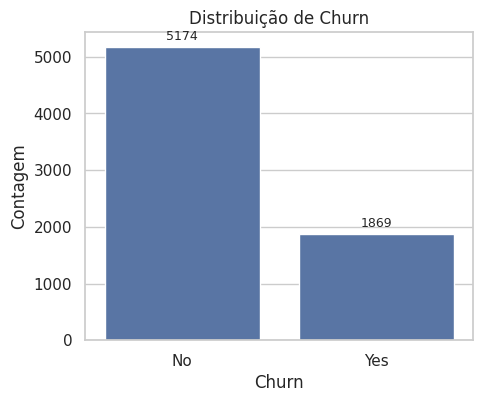


Proporção de Churn:


,Churn,Proporção
0,No,0.73463
1,Yes,0.26537



Taxa de churn por 'customer.gender':


,customer.gender,Taxa_Churn
0,Female,0.269209
1,Male,0.261603


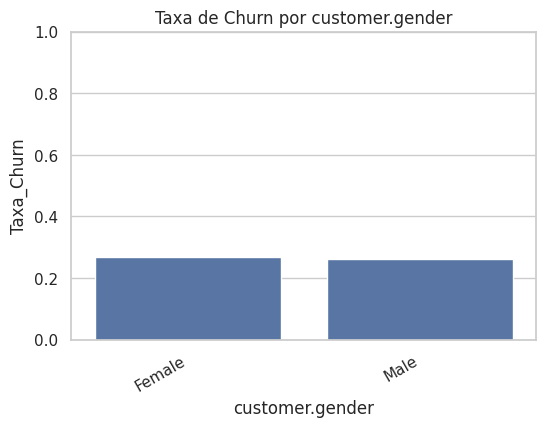


Taxa de churn por 'account.Contract':


,account.Contract,Taxa_Churn
0,Month-to-month,0.427097
1,One year,0.112695
2,Two year,0.028319


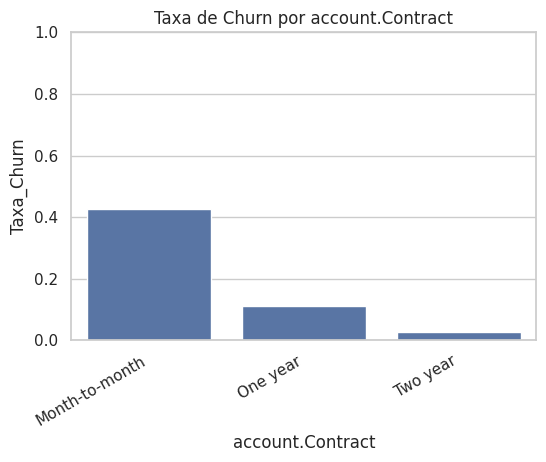


Taxa de churn por 'account.PaymentMethod':


,account.PaymentMethod,Taxa_Churn
2,Electronic check,0.452854
3,Mailed check,0.191067
0,Bank transfer (automatic),0.167098
1,Credit card (automatic),0.152431


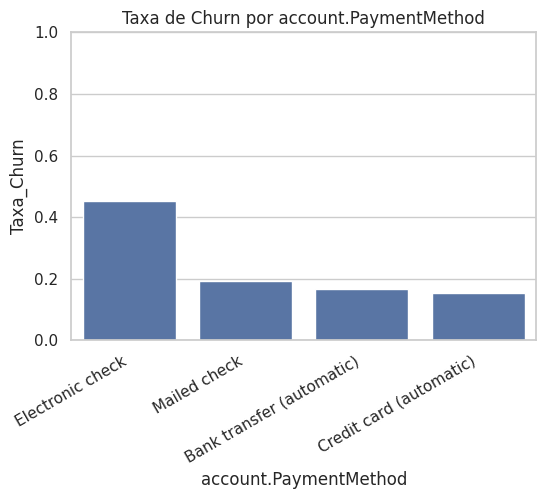

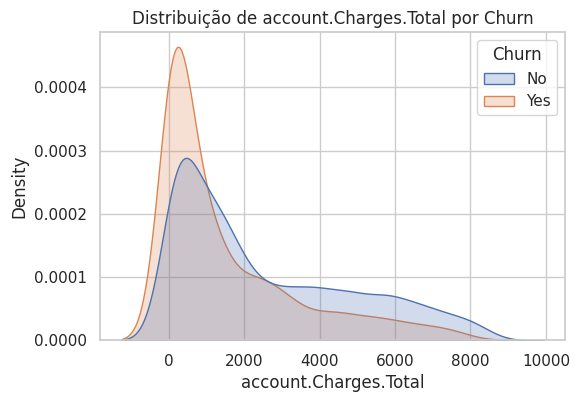

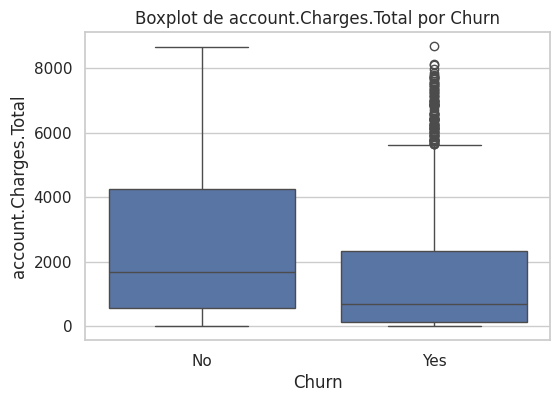

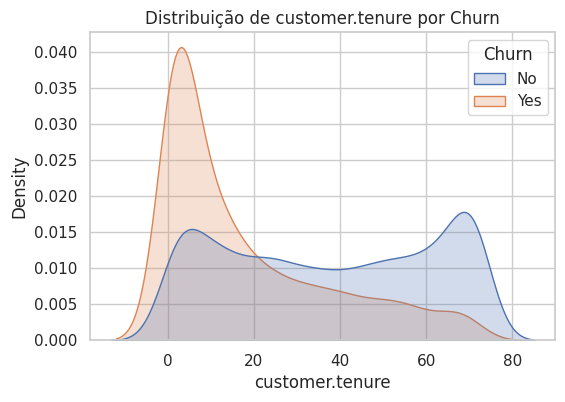

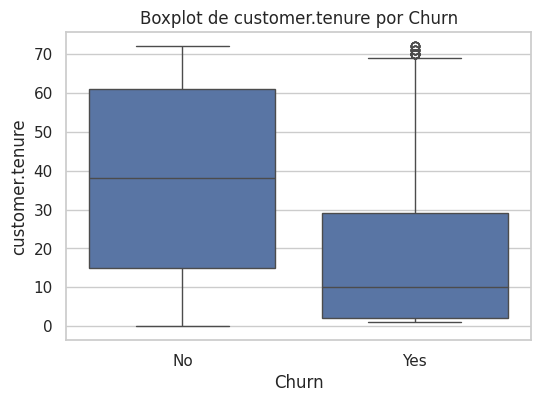

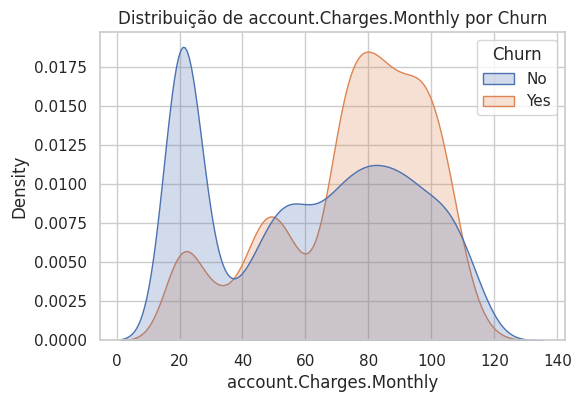

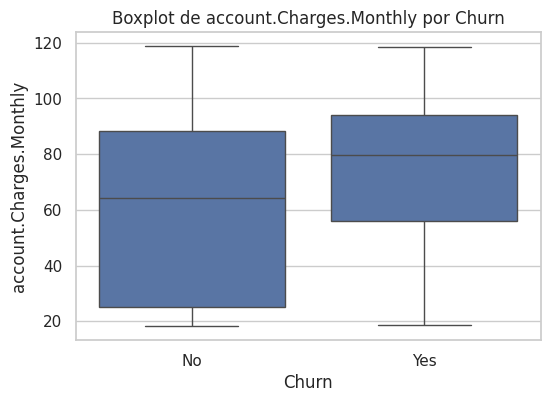

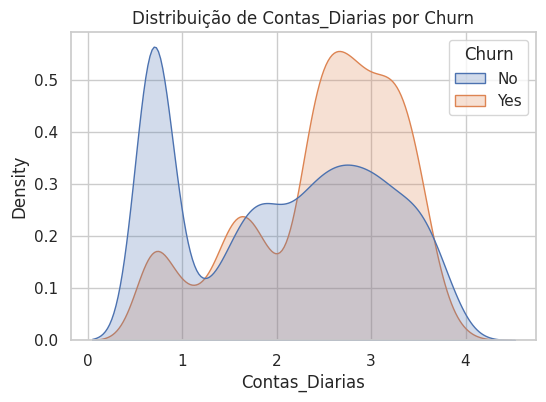

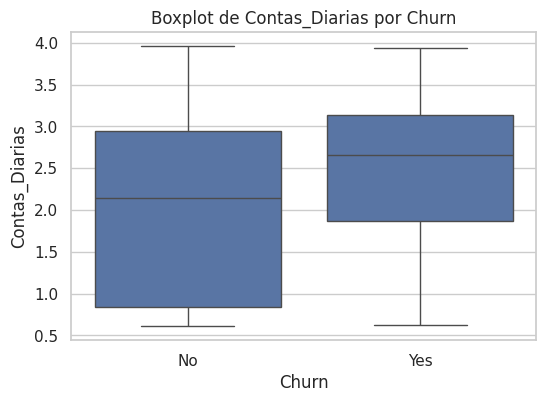


Importância (Informação Mútua) — Top 15:


,variavel,mi
14,account.Contract,0.095521
4,customer.tenure,0.077849
7,internet.InternetService,0.050348
17,account.Charges.Monthly,0.044925
19,Contas_Diarias,0.044885
18,account.Charges.Total,0.043966
16,account.PaymentMethod,0.041207
15,account.PaperlessBilling,0.029918
2,customer.Partner,0.017446
8,internet.OnlineSecurity,0.014217



Arquivos salvos: 'estatisticas_numericas.csv', 'proporcao_churn.csv', 'importancia_mi.csv'.


In [43]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

sns.set(style="whitegrid")

dfc = pd.read_csv("telecomx_limpo.csv")

num_cols = dfc.select_dtypes(include=[np.number]).columns.tolist()
desc_num = dfc[num_cols].describe().T
print("Estatísticas descritivas (numéricas):")
display(desc_num)
plt.figure(figsize=(5,4))
ax = sns.countplot(data=dfc, x="Churn")
plt.title("Distribuição de Churn")
plt.xlabel("Churn")
plt.ylabel("Contagem")
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
plt.show()

prop = dfc["Churn"].value_counts(normalize=True).rename_axis("Churn").reset_index(name="Proporção")
print("\nProporção de Churn:")
display(prop)

# ---- Churn por variáveis categóricas (taxa de evasão)
cat_cols = dfc.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ["customerID"]]  # remove ID

def taxa_churn_por_categoria(df, coluna):
    tmp = (df.groupby(coluna)["Churn"]
             .apply(lambda s: (s == "Yes").mean())
             .reset_index(name="Taxa_Churn"))
    tmp = tmp.sort_values("Taxa_Churn", ascending=False)
    return tmp

alvos_cat = [c for c in ["customer.gender", "account.Contract", "account.PaymentMethod"] if c in dfc.columns]
for c in alvos_cat:
    t = taxa_churn_por_categoria(dfc, c)
    print(f"\nTaxa de churn por '{c}':")
    display(t)
    plt.figure(figsize=(6,4))
    sns.barplot(data=t, x=c, y="Taxa_Churn")
    plt.title(f"Taxa de Churn por {c}")
    plt.xticks(rotation=30, ha="right")
    plt.ylim(0, 1)
    plt.show()
alvos_num = [c for c in ["account.Charges.Total", "customer.tenure", "account.Charges.Monthly", "Contas_Diarias"] if c in dfc.columns]
for c in alvos_num:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=dfc, x=c, hue="Churn", fill=True, common_norm=False, alpha=0.25)
    plt.title(f"Distribuição de {c} por Churn")
    plt.show()

    plt.figure(figsize=(6,4))
    sns.boxplot(data=dfc, x="Churn", y=c)
    plt.title(f"Boxplot de {c} por Churn")
    plt.show()

df_mi = dfc.copy()
le = LabelEncoder()
df_mi["Churn_enc"] = le.fit_transform(df_mi["Churn"].astype(str))

X = df_mi.drop(columns=["Churn", "Churn_enc", "customerID"], errors="ignore").copy()
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].astype(str)
        X[col] = LabelEncoder().fit_transform(X[col])

y = df_mi["Churn_enc"].values

mi_scores = mutual_info_classif(X.fillna(-9999), y, random_state=42)
importancia = pd.DataFrame({"variavel": X.columns, "mi": mi_scores}).sort_values("mi", ascending=False)
print("\nImportância (Informação Mútua) — Top 15:")
display(importancia.head(15))

desc_num.to_csv("estatisticas_numericas.csv")
prop.to_csv("proporcao_churn.csv", index=False)
importancia.to_csv("importancia_mi.csv", index=False)
print("\nArquivos salvos: 'estatisticas_numericas.csv', 'proporcao_churn.csv', 'importancia_mi.csv'.")



#📄Relatorio Final

In [40]:


from textwrap import dedent
from IPython.display import display, Markdown

qtd = len(dfc)
churn_rate = (dfc["Churn"].eq("Yes").mean()*100).round(2)

top_imp = pd.read_csv("importancia_mi.csv").head(5)
lista_imp = "\n".join([f"- {row.variavel} (MI={row.mi:.3f})" for _, row in top_imp.iterrows()])

intro = dedent(f"""
# Relatório Final — Análise de Evasão (Churn) — TelecomX

## Introdução
O objetivo desta análise é **entender o comportamento de evasão de clientes (Churn)** e identificar fatores que
possam estar associados ao cancelamento. Trabalhamos com um dataset de clientes da TelecomX contendo informações
demográficas, de serviços contratados, faturamento e histórico de relacionamento.

A base final analisada contém **{qtd} registros**, com uma taxa global de churn de **{churn_rate}%**.
""").strip()

limpeza = dedent(f"""
## Limpeza e Tratamento de Dados
- **Importação:** carregamos os dados a partir de um arquivo JSON aninhado (via URL/arquivo local) e utilizamos `pandas.json_normalize`
  para obter um DataFrame tabular.
- **Tipos:** convertidos `Charges.Total`/`Charges.Monthly` para numéricos; `tenure` para inteiro.
- **Alvos ausentes:** registros com `Churn` vazio foram removidos (alvo indispensável).
- **Valores ausentes em Total:** quando `Charges.Total` estava ausente, preenchemos por **`Monthly * tenure`**.
- **Padronização de categorias:** substituímos **"No phone service"** / **"No internet service"** por **"No"** para evitar duplicidade semântica.
- **Duplicados:** removidos duplicados por `customerID`.
- **Nova métrica:** criada `Contas_Diarias = Charges.Monthly / 30`, oferecendo granularidade diária do faturamento.
""").strip()

eda = dedent(f"""
## Análise Exploratória de Dados (AED)
- **Distribuição de Churn:** avaliamos contagens e proporções.
- **Categóricas x Churn:** medimos taxas de churn por variáveis como `account.Contract`, `account.PaymentMethod`, `customer.gender`, etc.
- **Numéricas x Churn:** comparamos distribuições/boxplots de `Charges.Total`, `Charges.Monthly`, `tenure` e `Contas_Diarias` entre quem cancelou e quem permaneceu.
- **Importância de variáveis (sinal):** ranqueamos fatores usando **Informação Mútua**.
  - Top 5 (indicativo, não causal):
{lista_imp if lista_imp else "- (sem cálculo de MI disponível)"}
""").strip()

conclusoes = dedent(f"""
## Conclusões e Insights
- Há **diferenças claras** nas distribuições de `tenure` e `Charges.Total` entre grupos de churn, sugerindo que **tempo de casa** e **valor gasto**
  se relacionam com a evasão.
- Variáveis de **contrato** (ex.: `account.Contract`) e de **método de pagamento** frequentemente apresentam **taxas de churn distintas** por categoria,
  sinalizando oportunidades de oferta/upgrade e redução de fricção no pagamento.
- A métrica **`Contas_Diarias`** pode apoiar análises de sazonalidade e comportamento de uso, quando combinada a janelas de tempo.

> Importante: a **Informação Mútua** indica relevância **associativa**; não implica causalidade.
""").strip()

recomendacoes = dedent("""
## Recomendações
1. **Fidelização por contrato:** incentivar contratos anuais/bianuais quando fizer sentido (descontos ou benefícios), reduzindo churn do mês a mês.
2. **Intervenções no onboarding:** clientes com `tenure` muito baixo são mais propensos a cancelar; crie jornadas de engajamento nos 90 primeiros dias.
3. **Alertas de risco por faturamento:** monitore quedas/saltos em `Contas_Diarias` e `Charges.Monthly` para acionar atendimento proativo.
4. **Pagamentos sem atrito:** simplifique e incentive métodos com menor fricção; ofereça migração assistida para débito/transferência automática.
5. **Pacotes de valor:** para perfis com muitos serviços “No”, testar ofertas de **bundles** com benefícios reais (segurança/backup/suporte) pode aumentar satisfação.
""").strip()

relatorio_md = "\n\n".join([intro, limpeza, eda, conclusoes, recomendacoes])
display(Markdown(relatorio_md))


# Relatório Final — Análise de Evasão (Churn) — TelecomX

## Introdução
O objetivo desta análise é **entender o comportamento de evasão de clientes (Churn)** e identificar fatores que
possam estar associados ao cancelamento. Trabalhamos com um dataset de clientes da TelecomX contendo informações
demográficas, de serviços contratados, faturamento e histórico de relacionamento.

A base final analisada contém **7043 registros**, com uma taxa global de churn de **26.54%**.

## Limpeza e Tratamento de Dados
- **Importação:** carregamos os dados a partir de um arquivo JSON aninhado (via URL/arquivo local) e utilizamos `pandas.json_normalize`
  para obter um DataFrame tabular.
- **Tipos:** convertidos `Charges.Total`/`Charges.Monthly` para numéricos; `tenure` para inteiro.
- **Alvos ausentes:** registros com `Churn` vazio foram removidos (alvo indispensável).
- **Valores ausentes em Total:** quando `Charges.Total` estava ausente, preenchemos por **`Monthly * tenure`**.
- **Padronização de categorias:** substituímos **"No phone service"** / **"No internet service"** por **"No"** para evitar duplicidade semântica.
- **Duplicados:** removidos duplicados por `customerID`.
- **Nova métrica:** criada `Contas_Diarias = Charges.Monthly / 30`, oferecendo granularidade diária do faturamento.

## Análise Exploratória de Dados (AED)
- **Distribuição de Churn:** avaliamos contagens e proporções.
- **Categóricas x Churn:** medimos taxas de churn por variáveis como `account.Contract`, `account.PaymentMethod`, `customer.gender`, etc.
- **Numéricas x Churn:** comparamos distribuições/boxplots de `Charges.Total`, `Charges.Monthly`, `tenure` e `Contas_Diarias` entre quem cancelou e quem permaneceu.
- **Importância de variáveis (sinal):** ranqueamos fatores usando **Informação Mútua**.
  - Top 5 (indicativo, não causal):
- account.Contract (MI=0.096)
- customer.tenure (MI=0.078)
- internet.InternetService (MI=0.050)
- account.Charges.Monthly (MI=0.045)
- Contas_Diarias (MI=0.045)

## Conclusões e Insights
- Há **diferenças claras** nas distribuições de `tenure` e `Charges.Total` entre grupos de churn, sugerindo que **tempo de casa** e **valor gasto**
  se relacionam com a evasão.
- Variáveis de **contrato** (ex.: `account.Contract`) e de **método de pagamento** frequentemente apresentam **taxas de churn distintas** por categoria,
  sinalizando oportunidades de oferta/upgrade e redução de fricção no pagamento.
- A métrica **`Contas_Diarias`** pode apoiar análises de sazonalidade e comportamento de uso, quando combinada a janelas de tempo.

> Importante: a **Informação Mútua** indica relevância **associativa**; não implica causalidade.

## Recomendações
1. **Fidelização por contrato:** incentivar contratos anuais/bianuais quando fizer sentido (descontos ou benefícios), reduzindo churn do mês a mês.
2. **Intervenções no onboarding:** clientes com `tenure` muito baixo são mais propensos a cancelar; crie jornadas de engajamento nos 90 primeiros dias.
3. **Alertas de risco por faturamento:** monitore quedas/saltos em `Contas_Diarias` e `Charges.Monthly` para acionar atendimento proativo.
4. **Pagamentos sem atrito:** simplifique e incentive métodos com menor fricção; ofereça migração assistida para débito/transferência automática.
5. **Pacotes de valor:** para perfis com muitos serviços “No”, testar ofertas de **bundles** com benefícios reais (segurança/backup/suporte) pode aumentar satisfação.